Objectives:-
- Preprocess and evaluate the MSLR Web 10k dataset
- Build a **ranking** model
- Evaluate the ranking model using a metric

# The Model

### 1) Imports

In [ ]:
# Import dependencies here

In [ ]:
# Install LightGBM
!pip install lightgbm

In [ ]:
# Install TF-Ranking and TF Dataset.
!pip install -q tensorflow-ranking
!pip install -q --upgrade tfds-nightly

     |████████████████████████████████| 141 kB 30.7 MB/s 
     |████████████████████████████████| 462 kB 72.0 MB/s 
     |████████████████████████████████| 4.3 MB 31.4 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pickle

import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale

import sklearn.linear_model
from sklearn.linear_model import LinearRegression

from sklearn import metrics

import lightgbm
from sklearn.metrics import ndcg_score

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_ranking as tfr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2) Download Dataset

In [ ]:
# Download the dataset located at https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip
# You can read about the features included in the dataset here: https://www.microsoft.com/en-us/research/project/mslr/


**Procedure**: Download the dataset. Unzip the the folder and remove all other folders except Fold1 (Due to memory and storage issues).

In [ ]:
!wget https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip
!unzip ./MSLR-WEB10K.zip
!rm -rf MSLR-WEB10K.zip Fold2 Fold3 Fold4 Fold5

--2022-04-18 07:37:08--  https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1234144912 (1.1G) [application/zip]
Saving to: ‘MSLR-WEB10K.zip’

MSLR-WEB10K.zip     100%[===================>]   1.15G  57.6MB/s    in 24s     

2022-04-18 07:37:33 (48.1 MB/s) - ‘MSLR-WEB10K.zip’ saved [1234144912/1234144912]

Archive:  ./MSLR-WEB10K.zip
   creating: Fold1/
  inflating: Fold1/test.txt          
  inflating: Fold1/train.txt         
  inflating: Fold1/vali.txt          
   creating: Fold2/
  inflating: Fold2/test.txt          
  inflating: Fold2/train.txt         
  inflating: Fold2/vali.txt          
   creating: Fold3/
  inflating: Fold3/test.txt          
  inflating: Fold3/train.txt         
  inflating: Fol

**Dataset Description**: 

The MSLR-Web10k dataset is a subset of the MSLR-Web30k dataset and was developed by Microsoft for the purpose of running learning to rank models. It contains 10000 unique queries randomly distributed among the 5 folds (k-fold cross validation used in dataset - k = 5) and 136 features. In each fold, there are separate train, validation and a test files. In the dataset, each row corresponds to a query-url pair and the columns are labels(0th column), query ids(1st) and features(2nd to 138th). Some of these features are covered query term number, IDF(Inverse document frequency), url click count, etc., and some of these span to 3-4 columns in the dataset.

**Procedure**: Create a pandas dataframe for the training, validation and test dataset from fold 1 of the dataset and print it.

In [ ]:
train_raw = pd.read_csv('./Fold1/train.txt', sep=" ", header=None)

In [ ]:
train_raw

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,2,qid:1,1:3,2:3,3:0,4:0,5:3,6:1,7:1,8:0,...,128:11089534,129:2,130:116,131:64034,132:13,133:3,134:0,135:0,136:0,NaN
1,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:11089534,129:2,130:124,131:64034,132:1,133:2,134:0,135:0,136:0,NaN
2,0,qid:1,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,...,128:3,129:1,130:124,131:3344,132:14,133:67,134:0,135:0,136:0,NaN
3,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:11089534,129:13,130:123,131:63933,132:1,133:3,134:0,135:0,136:0,NaN
4,1,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:5,129:7,130:256,131:49697,132:1,133:13,134:0,135:0,136:0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723407,0,qid:29992,1:2,2:0,3:1,4:1,5:2,6:1,7:0,8:0.50000,...,128:7,129:2,130:13829,131:35302,132:21,133:8,134:0,135:0,136:0,NaN
723408,0,qid:29992,1:2,2:1,3:1,4:1,5:2,6:1,7:0.50000,8:0.50000,...,128:0,129:0,130:26074,131:35101,132:14,133:7,134:1,135:0,136:0,NaN
723409,0,qid:29992,1:2,2:2,3:2,4:2,5:2,6:1,7:1,8:1,...,128:11,129:2,130:2995,131:62170,132:4,133:8,134:0,135:0,136:0,NaN
723410,0,qid:29992,1:2,2:0,3:0,4:0,5:2,6:1,7:0,8:0,...,128:0,129:0,130:138,131:56419,132:4,133:3,134:0,135:0,136:0,NaN


In [ ]:
validation_raw = pd.read_csv('./Fold1/vali.txt', sep=" ", header=None)
validation_raw

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,0,qid:10,1:2,2:0,3:0,4:0,5:2,6:0.666667,7:0,8:0,...,128:1,129:0,130:117,131:55115,132:7,133:2,134:0,135:0,136:0,NaN
1,0,qid:10,1:1,2:0,3:1,4:3,5:3,6:0.333333,7:0,8:0.333333,...,128:0,129:0,130:153,131:3866,132:17,133:104,134:0,135:0,136:0,NaN
2,1,qid:10,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:0,129:9,130:266,131:56137,132:5,133:2,134:0,135:0,136:0,NaN
3,0,qid:10,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,...,128:8,129:0,130:541,131:12621,132:11,133:11,134:0,135:0,136:0,NaN
4,1,qid:10,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:6,129:0,130:14687,131:40205,132:5,133:3,134:0,135:0,136:0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235254,2,qid:29995,1:1,2:0,3:0,4:0,5:1,6:0.50000,7:0,8:0,...,128:103,129:62,130:5131,131:65535,132:2,133:1,134:0,135:0,136:0,NaN
235255,2,qid:29995,1:1,2:0,3:1,4:0,5:1,6:0.50000,7:0,8:0.50000,...,128:428,129:2,130:1940,131:54880,132:7,133:4,134:0,135:0,136:0,NaN
235256,1,qid:29995,1:1,2:0,3:0,4:0,5:1,6:0.50000,7:0,8:0,...,128:24242,129:27,130:6135,131:51819,132:2,133:4,134:0,135:0,136:0,NaN
235257,2,qid:29995,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,...,128:100,129:0,130:3121,131:61234,132:49,133:6,134:0,135:0,136:0,NaN


In [ ]:
test_raw = pd.read_csv('./Fold1/test.txt', sep=" ", header=None)
test_raw

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,2,qid:13,1:2,2:0,3:2,4:1,5:2,6:1,7:0,8:1,...,128:1,129:0,130:266,131:25070,132:28,133:7,134:0,135:0,136:0,NaN
1,1,qid:13,1:2,2:0,3:0,4:0,5:2,6:1,7:0,8:0,...,128:93,129:0,130:153,131:12860,132:65,133:158,134:0,135:0,136:0,NaN
2,3,qid:13,1:2,2:0,3:1,4:0,5:2,6:1,7:0,8:0.50000,...,128:0,129:0,130:153,131:1131,132:112,133:141,134:0,135:0,136:0,NaN
3,1,qid:13,1:2,2:0,3:2,4:1,5:2,6:1,7:0,8:1,...,128:81775,129:0,130:560,131:61224,132:1,133:14,134:0,135:0,136:0,NaN
4,0,qid:13,1:1,2:0,3:0,4:0,5:1,6:0.50000,7:0,8:0,...,128:0,129:0,130:57953,131:15600,132:15,133:12,134:0,135:0,136:0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241516,1,qid:29998,1:3,2:0,3:1,4:1,5:3,6:1,7:0,8:0.333333,...,128:9,129:1,130:550,131:49786,132:23,133:102,134:0,135:0,136:0,NaN
241517,1,qid:29998,1:3,2:1,3:0,4:0,5:3,6:1,7:0.333333,8:0,...,128:268,129:0,130:181,131:53904,132:1,133:2,134:0,135:0,136:0,NaN
241518,1,qid:29998,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:14,129:9,130:4591,131:32817,132:3,133:9,134:0,135:0,136:0,NaN
241519,0,qid:29998,1:3,2:0,3:1,4:1,5:3,6:1,7:0,8:0.333333,...,128:0,129:1,130:1549,131:59332,132:10,133:4,134:0,135:0,136:0,NaN


### 3) Preprocess and evaluate the dataset

In [ ]:
# Preprocess and evaluate the dataset


**Procedure**: Find more information about the dataset using the .info() and .describe() functions

In [ ]:
train_raw.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723412 entries, 0 to 723411
Data columns (total 139 columns):
 #    Column  Dtype  
---   ------  -----  
 0    0       int64  
 1    1       object 
 2    2       object 
 3    3       object 
 4    4       object 
 5    5       object 
 6    6       object 
 7    7       object 
 8    8       object 
 9    9       object 
 10   10      object 
 11   11      object 
 12   12      object 
 13   13      object 
 14   14      object 
 15   15      object 
 16   16      object 
 17   17      object 
 18   18      object 
 19   19      object 
 20   20      object 
 21   21      object 
 22   22      object 
 23   23      object 
 24   24      object 
 25   25      object 
 26   26      object 
 27   27      object 
 28   28      object 
 29   29      object 
 30   30      object 
 31   31      object 
 32   32      object 
 33   33      object 
 34   34      object 
 35   35      object 
 36   36      object 
 37   37      object 
 38   38

**Observation**: There are 723412 rows and 139 columns, out of which the 0th column is int and 138th column is float and the remaining are objects.

In [ ]:
# 0 qid:1 1:3 2:0 3:2 4:2 … 135:0 136:0

# 2 qid:1 1:3 2:3 3:0 4:0 … 135:0 136:0

In [ ]:
train_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,2,qid:1,1:3,2:3,3:0,4:0,5:3,6:1,7:1,8:0,...,128:11089534,129:2,130:116,131:64034,132:13,133:3,134:0,135:0,136:0,NaN
1,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:11089534,129:2,130:124,131:64034,132:1,133:2,134:0,135:0,136:0,NaN
2,0,qid:1,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,...,128:3,129:1,130:124,131:3344,132:14,133:67,134:0,135:0,136:0,NaN
3,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:11089534,129:13,130:123,131:63933,132:1,133:3,134:0,135:0,136:0,NaN
4,1,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:5,129:7,130:256,131:49697,132:1,133:13,134:0,135:0,136:0,NaN


In [ ]:
train_raw.describe()

,0,138
count,723412.000000,0.0
mean,0.665307,NaN
std,0.822127,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,1.000000,NaN
max,4.000000,NaN


**Observation**: .describe() is not providing much information as there is a mix of dtypes in the dataframe.

In [ ]:
train_raw

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,2,qid:1,1:3,2:3,3:0,4:0,5:3,6:1,7:1,8:0,...,128:11089534,129:2,130:116,131:64034,132:13,133:3,134:0,135:0,136:0,NaN
1,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:11089534,129:2,130:124,131:64034,132:1,133:2,134:0,135:0,136:0,NaN
2,0,qid:1,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,...,128:3,129:1,130:124,131:3344,132:14,133:67,134:0,135:0,136:0,NaN
3,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:11089534,129:13,130:123,131:63933,132:1,133:3,134:0,135:0,136:0,NaN
4,1,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,...,128:5,129:7,130:256,131:49697,132:1,133:13,134:0,135:0,136:0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723407,0,qid:29992,1:2,2:0,3:1,4:1,5:2,6:1,7:0,8:0.50000,...,128:7,129:2,130:13829,131:35302,132:21,133:8,134:0,135:0,136:0,NaN
723408,0,qid:29992,1:2,2:1,3:1,4:1,5:2,6:1,7:0.50000,8:0.50000,...,128:0,129:0,130:26074,131:35101,132:14,133:7,134:1,135:0,136:0,NaN
723409,0,qid:29992,1:2,2:2,3:2,4:2,5:2,6:1,7:1,8:1,...,128:11,129:2,130:2995,131:62170,132:4,133:8,134:0,135:0,136:0,NaN
723410,0,qid:29992,1:2,2:0,3:0,4:0,5:2,6:1,7:0,8:0,...,128:0,129:0,130:138,131:56419,132:4,133:3,134:0,135:0,136:0,NaN


**Procedure**: Writing a function for:


1.   Separating the labels column and storing it and drop that column from the dataset
2.   Forming groups to find the counts of particular relevance per query id.
3.   Dropping 138th column before analyzing the data as the column is fully NaN. 
  

In [ ]:
# function to extract the actual relevance values from the dataset and drop labels and NaN column
def extractValue(df):
  # extract labels i.e., y
  labels = df[0]

  # create a dataframe with labels, queryids and count of particular relevance per query id
  df_group = pd.DataFrame(df.groupby([0, 1]).size().reset_index(name='counts'))
  df_group[1] = df_group[1].apply(lambda x: x.split(":")[-1])

  # remove the labels column from the dataframe
  df = df.drop(0, axis = 1)

  # extract the relevance value, that is in the format "featureId : relevance"
  df = df.applymap(lambda x: x.split(":")[-1], na_action='ignore')

  # removing the NaN column
  df = df.drop(138, axis = 1)
  
  return df, labels, df_group

In [ ]:
train_new, y_train, train_group = extractValue(train_raw)
validation_new, y_val, valid_group = extractValue(validation_raw)
test_new, y_test, test_group = extractValue(test_raw)

In [ ]:
train_new

,1,2,3,4,5,6,7,8,9,10,...,128,129,130,131,132,133,134,135,136,137
0,1,3,3,0,0,3,1,1,0,0,...,62,11089534,2,116,64034,13,3,0,0,0
1,1,3,0,3,0,3,1,0,1,0,...,54,11089534,2,124,64034,1,2,0,0,0
2,1,3,0,2,0,3,1,0,0.666667,0,...,45,3,1,124,3344,14,67,0,0,0
3,1,3,0,3,0,3,1,0,1,0,...,56,11089534,13,123,63933,1,3,0,0,0
4,1,3,0,3,0,3,1,0,1,0,...,64,5,7,256,49697,1,13,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723407,29992,2,0,1,1,2,1,0,0.50000,0.50000,...,39,7,2,13829,35302,21,8,0,0,0
723408,29992,2,1,1,1,2,1,0.50000,0.50000,0.50000,...,28,0,0,26074,35101,14,7,1,0,0
723409,29992,2,2,2,2,2,1,1,1,1,...,58,11,2,2995,62170,4,8,0,0,0
723410,29992,2,0,0,0,2,1,0,0,0,...,65,0,0,138,56419,4,3,0,0,0


In [ ]:
train_group

,0,1,counts
0,0,1,57
1,0,10006,29
2,0,10009,96
3,0,10012,22
4,0,10021,54
...,...,...,...
22346,4,9967,1
22347,4,997,1
22348,4,9982,1
22349,4,9991,4


In [ ]:
train_new.info(verbose = 'True')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723412 entries, 0 to 723411
Data columns (total 137 columns):
 #    Column  Dtype 
---   ------  ----- 
 0    1       object
 1    2       object
 2    3       object
 3    4       object
 4    5       object
 5    6       object
 6    7       object
 7    8       object
 8    9       object
 9    10      object
 10   11      object
 11   12      object
 12   13      object
 13   14      object
 14   15      object
 15   16      object
 16   17      object
 17   18      object
 18   19      object
 19   20      object
 20   21      object
 21   22      object
 22   23      object
 23   24      object
 24   25      object
 25   26      object
 26   27      object
 27   28      object
 28   29      object
 29   30      object
 30   31      object
 31   32      object
 32   33      object
 33   34      object
 34   35      object
 35   36      object
 36   37      object
 37   38      object
 38   39      object
 39   40      object
 40   

In [ ]:
train_new.describe()

,1,2,3,4,5,6,7,8,9,10,...,128,129,130,131,132,133,134,135,136,137
count,723412,723412,723412,723412,723412,723412,723412,723412,723412,723412,...,723412,723412,723412,723412,723412,723412,723412,723412,723412,723412
unique,6000,18,8,14,13,18,56,33,46,39,...,389,22158,134,64527,59944,254,255,3847,3356,62726
top,22636,2,0,1,0,2,1,0,1,0,...,35,0,0,144,65535,1,1,0,0,0
freq,809,238631,622917,246829,433121,243874,505957,622917,280315,433121,...,19747,254275,346665,11950,52059,156143,84831,698352,538900,540485


**Observation**: From here we can see that there are 6000 unique query ids (other 4000 distributed among validation and test datasets). The counts are consistant and no null values.

In [ ]:
# creating a pickle file to avoid performing the above preprocessing repeatedly
pickle_out = open("/content/drive/MyDrive/MSLR_Xtrain.pickle","wb")
pickle.dump(train_new, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/MSLR_ytrain.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()


In [ ]:
# pickle_in = open("/content/drive/MyDrive/MSLR_Xtrain.pickle","rb")
# df_train = pickle.load(pickle_in)
# pickle_in = open("/content/drive/MyDrive/MSLR_ytrain.pickle","rb")
# y_train = pickle.load(pickle_in)

In [ ]:
# pickle_in = open("/content/drive/MyDrive/MSLR_Xval.pickle","rb")
# df_val = pickle.load(pickle_in)
# pickle_in = open("/content/drive/MyDrive/MSLR_yval.pickle","rb")
# y_val = pickle.load(pickle_in)

In [ ]:
# pickle_in = open("/content/drive/MyDrive/MSLR_Xtest.pickle","rb")
# df_test = pickle.load(pickle_in)
# pickle_in = open("/content/drive/MyDrive/MSLR_ytest.pickle","rb")
# y_test = pickle.load(pickle_in)

In [ ]:
df_train = train_new
df_val = validation_new
df_test = test_new

In [ ]:
df_train

,1,2,3,4,5,6,7,8,9,10,...,128,129,130,131,132,133,134,135,136,137
0,1,3,3,0,0,3,1,1,0,0,...,62,11089534,2,116,64034,13,3,0,0,0
1,1,3,0,3,0,3,1,0,1,0,...,54,11089534,2,124,64034,1,2,0,0,0
2,1,3,0,2,0,3,1,0,0.666667,0,...,45,3,1,124,3344,14,67,0,0,0
3,1,3,0,3,0,3,1,0,1,0,...,56,11089534,13,123,63933,1,3,0,0,0
4,1,3,0,3,0,3,1,0,1,0,...,64,5,7,256,49697,1,13,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723407,29992,2,0,1,1,2,1,0,0.50000,0.50000,...,39,7,2,13829,35302,21,8,0,0,0
723408,29992,2,1,1,1,2,1,0.50000,0.50000,0.50000,...,28,0,0,26074,35101,14,7,1,0,0
723409,29992,2,2,2,2,2,1,1,1,1,...,58,11,2,2995,62170,4,8,0,0,0
723410,29992,2,0,0,0,2,1,0,0,0,...,65,0,0,138,56419,4,3,0,0,0


**Procedure**: Finding the number of datapoints in each relevance

In [ ]:
y_train.value_counts()

0    377957
1    232569
2     95082
3     12658
4      5146
Name: 0, dtype: int64

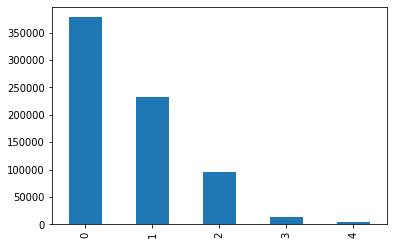

In [ ]:
y_train.value_counts().sort_values(ascending=False).plot(kind='bar')

**Observation**: This is an unbalanced dataset with most of the datapoints having relevance 0. Very few datapoints come under the relevance labels 3 and 4.

In [ ]:
df_train[1].nunique()

6000

In [ ]:
df_val

,1,2,3,4,5,6,7,8,9,10,...,128,129,130,131,132,133,134,135,136,137
0,10,2,0,0,0,2,0.666667,0,0,0,...,45,1,0,117,55115,7,2,0,0,0
1,10,1,0,1,3,3,0.333333,0,0.333333,1,...,76,0,0,153,3866,17,104,0,0,0
2,10,3,0,3,0,3,1,0,1,0,...,73,0,9,266,56137,5,2,0,0,0
3,10,3,0,2,0,3,1,0,0.666667,0,...,54,8,0,541,12621,11,11,0,0,0
4,10,3,0,3,0,3,1,0,1,0,...,36,6,0,14687,40205,5,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235254,29995,1,0,0,0,1,0.50000,0,0,0,...,36,103,62,5131,65535,2,1,0,0,0
235255,29995,1,0,1,0,1,0.50000,0,0.50000,0,...,58,428,2,1940,54880,7,4,0,0,0
235256,29995,1,0,0,0,1,0.50000,0,0,0,...,61,24242,27,6135,51819,2,4,0,0,0
235257,29995,0,0,0,0,0,0,0,0,0,...,42,100,0,3121,61234,49,6,0,0,0


In [ ]:
y_val

0         0
1         0
2         1
3         0
4         1
         ..
235254    2
235255    2
235256    1
235257    2
235258    1
Name: 0, Length: 235259, dtype: int64

In [ ]:
df_val[1].nunique()

2000

In [ ]:
# creating a pickle file to avoid performing the above preprocessing repeatedly
pickle_out = open("/content/drive/MyDrive/MSLR_Xval.pickle","wb")
pickle.dump(validation_new, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/MSLR_yval.pickle","wb")
pickle.dump(y_val, pickle_out)
pickle_out.close()

In [ ]:
df_test

,1,2,3,4,5,6,7,8,9,10,...,128,129,130,131,132,133,134,135,136,137
0,13,2,0,2,1,2,1,0,1,0.50000,...,35,1,0,266,25070,28,7,0,0,0
1,13,2,0,0,0,2,1,0,0,0,...,17,93,0,153,12860,65,158,0,0,0
2,13,2,0,1,0,2,1,0,0.50000,0,...,19,0,0,153,1131,112,141,0,0,0
3,13,2,0,2,1,2,1,0,1,0.50000,...,50,81775,0,560,61224,1,14,0,0,0
4,13,1,0,0,0,1,0.50000,0,0,0,...,24,0,0,57953,15600,15,12,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241516,29998,3,0,1,1,3,1,0,0.333333,0.333333,...,60,9,1,550,49786,23,102,0,0,0
241517,29998,3,1,0,0,3,1,0.333333,0,0,...,91,268,0,181,53904,1,2,0,0,0
241518,29998,3,0,3,0,3,1,0,1,0,...,69,14,9,4591,32817,3,9,0,0,0
241519,29998,3,0,1,1,3,1,0,0.333333,0.333333,...,51,0,1,1549,59332,10,4,0,0,0


In [ ]:
y_test

0         2
1         1
2         3
3         1
4         0
         ..
241516    1
241517    1
241518    1
241519    0
241520    0
Name: 0, Length: 241521, dtype: int64

In [ ]:
df_test[1].nunique()

2000

In [ ]:
# creating a pickle file to avoid performing the above preprocessing repeatedly
pickle_out = open("/content/drive/MyDrive/MSLR_Xtest.pickle","wb")
pickle.dump(test_new, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/MSLR_ytest.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [ ]:
train_group.loc[train_group[1] == '1']

,0,1,counts
0,0,1,57
5999,1,1,16
11799,2,1,12
17195,3,1,1


In [ ]:
train_group.loc[train_group[1] == '10006']

,0,1,counts
1,0,10006,29
6000,1,10006,10
17196,3,10006,1


In [ ]:
train_group.loc[train_group[1] == '9991']

,0,1,counts
5996,0,9991,14
11796,1,9991,30
17193,2,9991,26
20687,3,9991,4
22349,4,9991,4


**Observation**: For each query id there could be documents in all 5 relevance labels

**Procedure**: For understanding the dataset, find the number of documents that have only zero relevance

In [ ]:
# function to find the number of documents that have only zero relevance
def countOnlyZeroRelevance(df):
  zero_relevance = set(pd.DataFrame(df.loc[df[0] == 0])[1])
  allOther_relevance = set(pd.DataFrame(df.loc[df[0] > 0])[1])

  count = 0
  for queryId in zero_relevance:
    if queryId in allOther_relevance:
      continue
    else:
      count += 1
  return count

In [ ]:
countOnlyZero_train = countOnlyZeroRelevance(train_group)
countOnlyZero_train

182

In [ ]:
countOnlyZero_valid = countOnlyZeroRelevance(valid_group)
countOnlyZero_valid

61

In [ ]:
countOnlyZero_test = countOnlyZeroRelevance(test_group)
countOnlyZero_test

72

**Observation**: There are 182 documents in the training set, 61 in validation and 72 in test set which have only zero relevance.

**Observation**: Some values among the features seem to be as low as 0 and 0.5 and some as high as 11089534

***Dimensionality Reduction***

1.   Low Variance
2.   High Correlation
3.   Lasso Regression - L1 regularization



**Low Variance**

**Procedure**: Finding columns with low variance for dimensionality reduction

In [ ]:
lowVariance = df_train.astype('float64').var()

In [ ]:
lowVariance

1      6.872371e+07
2      1.652899e+00
3      3.298092e-01
4      1.041114e+00
5      6.275064e-01
           ...     
133    9.251268e+02
134    1.704566e+03
135    8.009604e+08
136    3.760945e+08
137    1.194405e+13
Length: 137, dtype: float64

In [ ]:
countLV = 0
lowVarianceIndex = []
for i in range(len(lowVariance)):
  txt = str(lowVariance.iloc[i])
  if float(txt) < 1 or 'e-' in txt:
    lowVarianceIndex.append(i+1)
    countLV += 1
print(countLV)
print(lowVarianceIndex)

51
[3, 5, 7, 8, 9, 10, 11, 25, 28, 29, 30, 33, 35, 38, 40, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106]


In [ ]:
# function to drop the low variance features from the dataset
def dropLowVarianceReducedFeatures(df):
  return df.drop(lowVarianceIndex, axis = 1)

In [ ]:
# reduce the datasets by removing the 51 features
X_train_LV = dropLowVarianceReducedFeatures(df_train)
X_val_LV = dropLowVarianceReducedFeatures(df_val)
X_test_LV = dropLowVarianceReducedFeatures(df_test)

In [ ]:
X_train_LV

,1,2,4,6,12,13,14,15,16,17,...,128,129,130,131,132,133,134,135,136,137
0,1,3,0,3,156,4,0,7,167,6.931275,...,62,11089534,2,116,64034,13,3,0,0,0
1,1,3,3,3,406,0,5,5,416,6.931275,...,54,11089534,2,124,64034,1,2,0,0,0
2,1,3,2,3,146,0,3,7,156,6.931275,...,45,3,1,124,3344,14,67,0,0,0
3,1,3,3,3,287,1,4,7,299,6.931275,...,56,11089534,13,123,63933,1,3,0,0,0
4,1,3,3,3,2009,2,4,7,2022,6.931275,...,64,5,7,256,49697,1,13,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723407,29992,2,1,2,63,2,3,7,75,19.036284,...,39,7,2,13829,35302,21,8,0,0,0
723408,29992,2,1,2,63,4,3,5,75,19.036284,...,28,0,0,26074,35101,14,7,1,0,0
723409,29992,2,2,2,588,4,5,9,606,19.036284,...,58,11,2,2995,62170,4,8,0,0,0
723410,29992,2,0,2,319,0,2,11,332,19.036284,...,65,0,0,138,56419,4,3,0,0,0


**Observation and Inference**: 51 features have low variance. Low variance features do not contribute to the improvisation of the model.

**High Correlation**

**Procedure**: Find the correlation of the features and reduce highly correlated features

In [ ]:
cor = df_train.astype('float64').corr()           # since .corr() will not work on objects
cor

,1,2,3,4,5,6,7,8,9,10,...,128,129,130,131,132,133,134,135,136,137
1,1.000000,-0.012832,-0.016225,0.014290,0.023520,-0.012908,0.006863,-0.011052,0.030105,0.038365,...,0.043662,-0.002183,0.020536,-0.022218,0.039000,0.007427,-0.028623,0.002902,-0.001165,0.000294
2,-0.012832,1.000000,0.129243,0.533616,0.161193,0.981197,0.568620,0.005768,0.152940,-0.109165,...,0.142942,-0.003565,0.022704,-0.155458,-0.069980,-0.098014,0.051162,-0.004920,-0.019908,-0.000072
3,-0.016225,0.129243,1.000000,0.215113,0.203076,0.140679,0.122597,0.886385,0.161183,0.139712,...,0.073495,0.000156,0.181217,0.057409,0.068316,-0.000665,0.043733,-0.000602,-0.007287,0.000049
4,0.014290,0.533616,0.215113,1.000000,0.329523,0.510710,0.485634,0.127520,0.763987,0.124613,...,0.123502,-0.001818,0.055902,-0.132749,-0.048722,-0.042245,0.075021,-0.001362,-0.020440,-0.001596
5,0.023520,0.161193,0.203076,0.329523,1.000000,0.200767,0.165073,0.170657,0.259767,0.827097,...,0.256278,0.005946,0.090015,-0.116502,0.133382,0.073772,0.093694,0.001861,-0.011550,-0.001223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.007427,-0.098014,-0.000665,-0.042245,0.073772,-0.069204,-0.180226,-0.017075,-0.074790,0.059086,...,-0.033987,0.006799,-0.091446,-0.107150,-0.226656,1.000000,0.444621,-0.000521,-0.003761,-0.001780
134,-0.028623,0.051162,0.043733,0.075021,0.093694,0.050900,0.003397,0.019368,0.028144,0.038792,...,-0.056066,-0.001176,-0.054439,-0.128041,-0.330588,0.444621,1.000000,-0.000145,-0.010839,0.000253
135,0.002902,-0.004920,-0.000602,-0.001362,0.001861,-0.005116,0.001216,0.000472,0.004930,0.007644,...,-0.007417,0.000502,0.001797,0.012488,0.007545,-0.000521,-0.000145,1.000000,0.030649,-0.000021
136,-0.001165,-0.019908,-0.007287,-0.020440,-0.011550,-0.021232,-0.029962,-0.007353,-0.022044,-0.011489,...,-0.030266,0.000089,0.012711,0.047835,0.029147,-0.003761,-0.010839,0.030649,1.000000,-0.000122


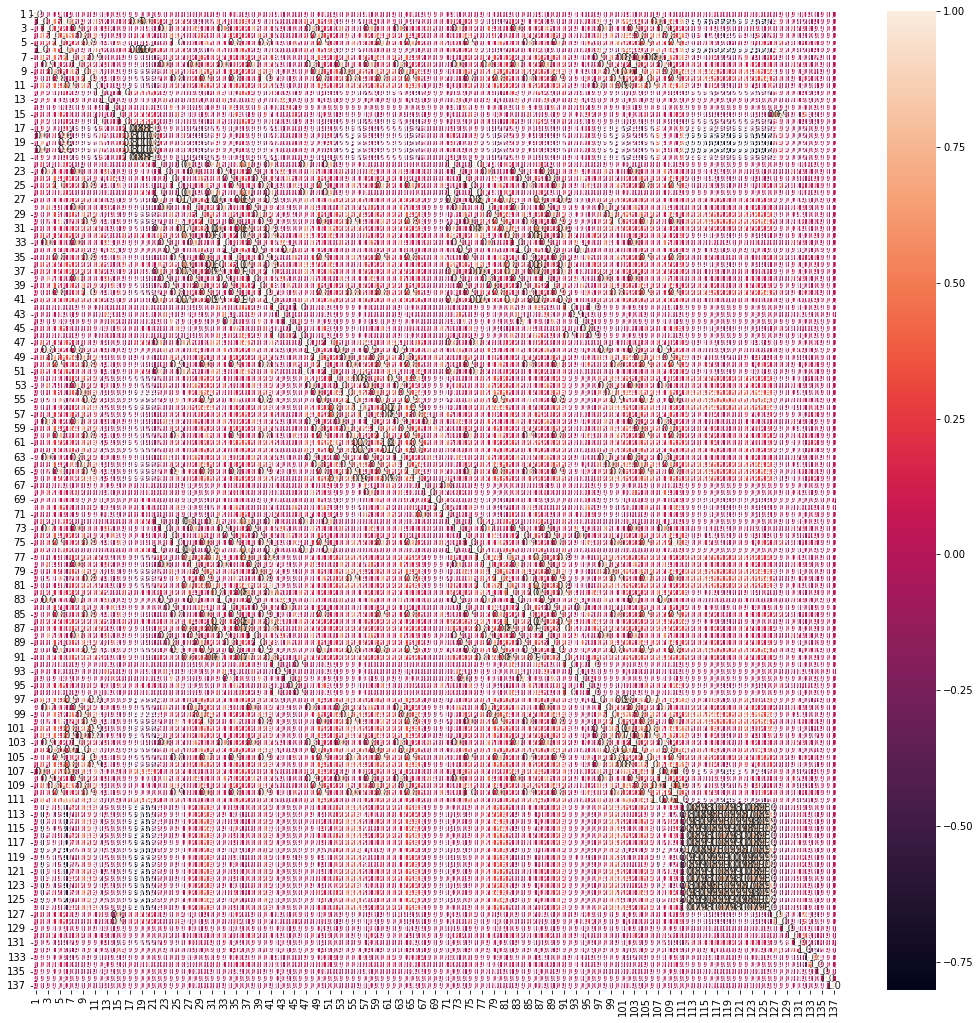

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(cor, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

**Inference**: Couldn't reduce the features using the high correlation method due to large number of features and absense of readability

**Lasso Regression - L1 regularization**

In [ ]:
lasso_rgr = Lasso(alpha=0.1)
lasso_rgr.fit(df_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.160e+05, tolerance: 4.889e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso(alpha=0.1)

In [ ]:
pred_lasso = lasso_rgr.predict(df_val)

In [ ]:
print("MSE:", mean_squared_error(y_val, pred_lasso))

MSE: 0.616849667528529


In [ ]:
# find best alpha for regularization
lasso_best = sklearn.linear_model.LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_best.fit(scale(df_train), y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.913e+01, tolerance: 4.889e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


LassoCV(cv=10, max_iter=10000)

In [ ]:
# # try fitting with the best alpha and fit the training dataset and find MSE
lasso_rgr.set_params(alpha=lasso_best.alpha_)
lasso_rgr.fit(scale(df_train), y_train)
mean_squared_error(y_val, lasso_rgr.predict(scale(df_val)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e+05, tolerance: 4.889e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


0.6054241617566706

In [ ]:
lasso_best.alpha_

0.0001973327876043028

In [ ]:
# find features with zero value coefficients, reduced by Lasso Regression
zeroValue_series = pd.Series(lasso_best.coef_, index=df_train.columns)
zeroValue_series

1      0.038360
2     -0.033377
3      0.016191
4     -0.052692
5     -0.000000
         ...   
133    0.010961
134   -0.040704
135    0.008849
136   -0.003324
137    0.001082
Length: 137, dtype: float64

In [ ]:
zeroValue_series.iloc[0]

0.03836023704260401

In [ ]:
# find the count and the features with zero value coeeficients
countFeatures = 0
zeroValue_features = []
for i in range(len(zeroValue_series)):
  if zeroValue_series.iloc[i] == 0:
    zeroValue_features.append(i+1)
    countFeatures += 1
print(countFeatures)
print(zeroValue_features)

38
[5, 8, 14, 17, 20, 22, 26, 27, 32, 35, 36, 38, 40, 41, 42, 48, 50, 51, 53, 59, 64, 73, 78, 80, 81, 82, 84, 86, 87, 89, 92, 95, 100, 101, 112, 117, 123, 125]


**Observation**: These features can be removed from the dataset as they do not add value to the training. 

In [ ]:
# function to drop the features based on Lasso regression
def dropLassoReducedFeatures(df):
  return df.drop(zeroValue_features, axis = 1)

In [ ]:
X_train_lasso = dropLassoReducedFeatures(df_train)
X_val_lasso = dropLassoReducedFeatures(df_val)
X_test_lasso = dropLassoReducedFeatures(df_test)

In [ ]:
# creating a pickle file to avoid performing the above preprocessing repeatedly
pickle_out = open("/content/drive/MyDrive/MSLR_Xtrain_Lasso.pickle","wb")
pickle.dump(X_train_lasso, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("/content/drive/MyDrive/MSLR_Xvalid_Lasso.pickle","wb")
pickle.dump(X_val_lasso, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("/content/drive/MyDrive/MSLR_Xtest_Lasso.pickle","wb")
pickle.dump(X_test_lasso, pickle_out)
pickle_out.close()

In [ ]:
# pickle_in = open("/content/drive/MyDrive/MSLR_Xtrain_Lasso.pickle","rb")
# X_train_lasso = pickle.load(pickle_in)

In [ ]:
# pickle_in = open("/content/drive/MyDrive/MSLR_Xvalid_Lasso.pickle","rb")
# X_val_lasso = pickle.load(pickle_in)

In [ ]:
# pickle_in = open("/content/drive/MyDrive/MSLR_Xtest_Lasso.pickle","rb")
# X_test_lasso = pickle.load(pickle_in)

In [ ]:
X_train_lasso

,1,2,3,4,6,7,9,10,11,12,...,128,129,130,131,132,133,134,135,136,137
0,1,3,3,0,3,1,0,0,1,156,...,62,11089534,2,116,64034,13,3,0,0,0
1,1,3,0,3,3,1,1,0,1,406,...,54,11089534,2,124,64034,1,2,0,0,0
2,1,3,0,2,3,1,0.666667,0,1,146,...,45,3,1,124,3344,14,67,0,0,0
3,1,3,0,3,3,1,1,0,1,287,...,56,11089534,13,123,63933,1,3,0,0,0
4,1,3,0,3,3,1,1,0,1,2009,...,64,5,7,256,49697,1,13,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723407,29992,2,0,1,2,1,0.50000,0.50000,1,63,...,39,7,2,13829,35302,21,8,0,0,0
723408,29992,2,1,1,2,1,0.50000,0.50000,1,63,...,28,0,0,26074,35101,14,7,1,0,0
723409,29992,2,2,2,2,1,1,1,1,588,...,58,11,2,2995,62170,4,8,0,0,0
723410,29992,2,0,0,2,1,0,0,1,319,...,65,0,0,138,56419,4,3,0,0,0


**Observation**: This is the Lasso regression feature reduced dataset. 38 features have been removed.

### 4) Build ranking model

In [ ]:
# Approach:-
# source: http://ltr-tutorial-sigir19.isti.cnr.it/wp-content/uploads/2019/07/Part-II.pdf
# • Training efficient Tree-based models for document ranking - Experiments on MSLR-WEB10K show that the "pruning" approach is superior (slide 14)

# Approach:-
# source: https://towardsdatascience.com/learning-to-rank-a-complete-guide-to-ranking-using-machine-learning-4c9688d370d4
# Discounted Cumulative Gain: Used for tasks with graded relevance (labels - 0 to 4)
# *Note from above source*: Discounted Cumulative Gain is used for tasks with graded relevance, i.e. when the true score y of a document d is a discrete value in a scale measuring the relevance w.r.t. a query q. A typical scale is 0 (bad), 1 (fair), 2 (good), 3 (excellent), 4 (perfect).
# For a given query q and corresponding documents D = {d₁, …, dₙ}, we consider the the k-th top retrieved document. The gain Gₖ = 2^yₖ – 1 measures how useful is this document (we want documents with high relevance!), while the discount Dₖ = 1/log(k+1) penalizes documents that are retrieved with a lower rank (we want relevant documents in the top ranks!).
# The sum of the discounted gain terms GₖDₖ for k = 1…n is the Discounted Cumulative Gain (DCG). To make sure that this score is bound between 0 and 1, we can divide the measured DCG by the ideal score IDCG obtained if we ranked documents by the true value yₖ. This gives us the Normalized Discounted Cumulative Gain (NDCG), where NDCG = DCG/IDCG.

In [ ]:
# Build ranking model

# Approach:-
# 1. Naive methods - Classification and regression using usual ML techniques - Pointwise? - Linear Regression and XGBoost
# 3. Listwise

# Algorithms
# RankNet, LambdaRank and LambdaMART - In all three techniques, ranking is transformed into a pairwise classification or regression problem.


**NAIVE METHOD: Linear Regression**

*Case 1: With the original dataset*

In [ ]:
# Using Linear Regression - .fit()
rgr = LinearRegression()
rgr.fit(df_train, y_train)

LinearRegression()

In [ ]:
# find predictions
pred_lr = rgr.predict(df_val)

In [ ]:
# calculate the MSE
print("MSE:", mean_squared_error(y_val,pred_lr))

MSE: 0.6030014476026082


*Case 2: With the reduced features - Lasso reduced*

In [ ]:
rgr_lasso = LinearRegression()
rgr_lasso.fit(X_train_lasso, y_train)

LinearRegression()

In [ ]:
pred_lr_lasso = rgr_lasso.predict(X_val_lasso)

In [ ]:
print("MSE:", mean_squared_error(y_val, pred_lr_lasso))

MSE: 0.6028009334052414


*Case 3: With the reduced features - Low Variance reduced*

In [ ]:
rgr_LV = LinearRegression()
rgr_LV.fit(X_train_LV, y_train)

LinearRegression()

In [ ]:
pred_lr_LV = rgr_LV.predict(X_test_LV)

In [ ]:
print("MSE:", mean_squared_error(y_test, pred_lr_LV))

MSE: 0.6083079144466826


**Observation**: All the MSE values are the same. There seems to be no improvement in the model.

**LightGBM Ranking**

**Reference**: https://tamaracucumides.medium.com/learning-to-rank-with-lightgbm-code-example-in-python-843bd7b44574

**Procedure**: Written a function to:-

1.   Separate out the query ids
2.   Convert the dtype of columns of the dataset from 'object' to 'int64'
3.   Convert labels to numpy 1D array


In [ ]:
def preprocessLightGBM(df, labels):
  # extract the qids numpy array
  qids = df.groupby(1)[1].count().to_numpy()

  # convert the dtype of all column values from 'object' to 'int64'
  df = df.apply(pd.to_numeric)

  # convert labels to numpy 1D array
  labels = labels.ravel()

  return df, qids, labels

In [ ]:
df_train, qids_train, y_train = preprocessLightGBM(df_train, y_train)
df_val, qids_val, y_val = preprocessLightGBM(df_val, y_val)
df_test, qids_test, y_test = preprocessLightGBM(df_test, y_test)

In [ ]:
df_train

,1,2,3,4,5,6,7,8,9,10,...,128,129,130,131,132,133,134,135,136,137
0,1,3,3,0,0,3,1.0,1.0,0.000000,0.0,...,62,11089534,2,116,64034,13,3,0,0,0.0
1,1,3,0,3,0,3,1.0,0.0,1.000000,0.0,...,54,11089534,2,124,64034,1,2,0,0,0.0
2,1,3,0,2,0,3,1.0,0.0,0.666667,0.0,...,45,3,1,124,3344,14,67,0,0,0.0
3,1,3,0,3,0,3,1.0,0.0,1.000000,0.0,...,56,11089534,13,123,63933,1,3,0,0,0.0
4,1,3,0,3,0,3,1.0,0.0,1.000000,0.0,...,64,5,7,256,49697,1,13,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723407,29992,2,0,1,1,2,1.0,0.0,0.500000,0.5,...,39,7,2,13829,35302,21,8,0,0,0.0
723408,29992,2,1,1,1,2,1.0,0.5,0.500000,0.5,...,28,0,0,26074,35101,14,7,1,0,0.0
723409,29992,2,2,2,2,2,1.0,1.0,1.000000,1.0,...,58,11,2,2995,62170,4,8,0,0,0.0
723410,29992,2,0,0,0,2,1.0,0.0,0.000000,0.0,...,65,0,0,138,56419,4,3,0,0,0.0


In [ ]:
qids_train

array([ 86,  40, 206, ...,  78, 117,  76])

In [ ]:
y_train

0         2
1         2
2         0
3         2
4         1
         ..
723407    0
723408    0
723409    0
723410    0
723411    1
Name: 0, Length: 723412, dtype: int64

**Procedure**: Define the LightGBM ranker model and fit the dataset

In [ ]:
model_gbm = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
)

In [ ]:
model_gbm.fit(
    X=df_train,
    y=y_train,
    group=qids_train,
    eval_set=[(df_val, y_val)],
    eval_group=[qids_val],
    eval_at=10,
    verbose=10,
)

[10]	valid_0's ndcg@10: 0.452632
[20]	valid_0's ndcg@10: 0.463973
[30]	valid_0's ndcg@10: 0.470717
[40]	valid_0's ndcg@10: 0.476898
[50]	valid_0's ndcg@10: 0.484989
[60]	valid_0's ndcg@10: 0.489415
[70]	valid_0's ndcg@10: 0.491706
[80]	valid_0's ndcg@10: 0.494644
[90]	valid_0's ndcg@10: 0.497434
[100]	valid_0's ndcg@10: 0.49908


LGBMRanker(metric='ndcg', objective='lambdarank')

In [ ]:
# model_gbm.fit(
#     X=df_train,
#     y=y_train,
#     group=qids_train,
#     eval_set=[(X_validation, y_val)],
#     eval_group=[qids_validation],
#     eval_at=10,
#     verbose=10,
# )

[10]	valid_0's ndcg@10: 0.440585
[20]	valid_0's ndcg@10: 0.451921
[30]	valid_0's ndcg@10: 0.459668
[40]	valid_0's ndcg@10: 0.465093
[50]	valid_0's ndcg@10: 0.472058
[60]	valid_0's ndcg@10: 0.477445
[70]	valid_0's ndcg@10: 0.48103
[80]	valid_0's ndcg@10: 0.483814
[90]	valid_0's ndcg@10: 0.486266
[100]	valid_0's ndcg@10: 0.488316


LGBMRanker(metric='ndcg', objective='lambdarank')

In [ ]:
pickle_out = open("/content/drive/MyDrive/MSLR_XtrainGBM.pickle","wb")
pickle.dump(df_train, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("/content/drive/MyDrive/MSLR_XvalidGBM.pickle","wb")
pickle.dump(df_val, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("/content/drive/MyDrive/MSLR_XtestGBM.pickle","wb")
pickle.dump(df_test, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("/content/drive/MyDrive/MSLR_XtrainGBM.pickle","rb")
X_train = pickle.load(pickle_in)

In [ ]:
pickle_in = open("/content/drive/MyDrive/MSLR_XvalidGBM.pickle","rb")
X_validation = pickle.load(pickle_in)

In [ ]:
pickle_in = open("/content/drive/MyDrive/MSLR_XtestGBM.pickle","rb")
X_test = pickle.load(pickle_in)

**Procedure**: Using regularization by introducing early stopping to reduce the complexity of the model.

In [ ]:
model_gbm_reg = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
)

In [ ]:
model_gbm_reg.fit(
    X=df_train,
    y=y_train,
    group=qids_train,
    eval_set=[(df_val, y_val)],
    eval_group=[qids_val],
    eval_at=10,
    verbose=10,
    early_stopping_rounds=50,
)

Training until validation scores don't improve for 50 rounds.
[10]	valid_0's ndcg@10: 0.452632
[20]	valid_0's ndcg@10: 0.463973
[30]	valid_0's ndcg@10: 0.470717
[40]	valid_0's ndcg@10: 0.476898
[50]	valid_0's ndcg@10: 0.484989
[60]	valid_0's ndcg@10: 0.489415
[70]	valid_0's ndcg@10: 0.491706
[80]	valid_0's ndcg@10: 0.494644
[90]	valid_0's ndcg@10: 0.497434
[100]	valid_0's ndcg@10: 0.49908
Did not meet early stopping. Best iteration is:
[100]	valid_0's ndcg@10: 0.49908


LGBMRanker(metric='ndcg', objective='lambdarank')

**Tensorflow Ranking**

**Reference**: https://www.tensorflow.org/ranking

**Procedure**: Load the dataset from the tensorflow dataset library

In [ ]:
# loading dataset from tensorflow dataset library
ds = tfds.load("mslr_web")

In [ ]:
ds.keys()

dict_keys(['train', 'vali', 'test'])

In [ ]:
ds['train']

<PrefetchDataset element_spec={'bm25_anchor': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bm25_body': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bm25_title': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bm25_url': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bm25_whole_document': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_anchor': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_body': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_title': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_url': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_whole_document': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'covered_query_term_number_anchor': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'covered_query_term_number_body': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'covered_query_term_number_t

In [ ]:
ds['test']

<PrefetchDataset element_spec={'bm25_anchor': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bm25_body': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bm25_title': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bm25_url': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bm25_whole_document': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_anchor': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_body': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_title': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_url': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'boolean_model_whole_document': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'covered_query_term_number_anchor': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'covered_query_term_number_body': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'covered_query_term_number_t

**Procedure**: For preprocessing the data:

1.   Adding a mask tensor to the dataset (False for padded items).
2.   Shuffle the dataset to avoid any bias due to order and pad the inputs with different length.
3.   Construct tuples (feature, label) and label is -1 if masked


In [ ]:
def preprocess(data):
  preprocess_data = data.map(lambda feature_map: {
      "_mask": tf.ones_like(feature_map["label"], dtype=tf.bool),
      **feature_map
  })
  preprocess_data = preprocess_data.shuffle(buffer_size=1000).padded_batch(batch_size=32)
  preprocess_data = preprocess_data.map(lambda feature_map: (
      feature_map, tf.where(feature_map["_mask"], feature_map.pop("label"), -1.)))
  return preprocess_data

In [ ]:
ds['train'] = preprocess(ds['train'])
ds['test'] = preprocess(ds['test'])

In [ ]:
ds['train']

<MapDataset element_spec=({'_mask': TensorSpec(shape=(None, None), dtype=tf.bool, name=None), 'bm25_anchor': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'bm25_body': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'bm25_title': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'bm25_url': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'bm25_whole_document': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_anchor': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_body': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_title': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_url': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_whole_document': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'covered_query_term_number_anchor': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 

In [ ]:
ds['test']

<MapDataset element_spec=({'_mask': TensorSpec(shape=(None, None), dtype=tf.bool, name=None), 'bm25_anchor': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'bm25_body': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'bm25_title': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'bm25_url': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'bm25_whole_document': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_anchor': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_body': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_title': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_url': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'boolean_model_whole_document': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 'covered_query_term_number_anchor': TensorSpec(shape=(None, None), dtype=tf.float64, name=None), 

*Case 1: Neural network with a 3 layer architecture, with 128, 64 and 32 neurons*

**Procedure**: Define the input format and normalize the input

In [ ]:
# format input
inputs = {
    name: tf.keras.Input(shape=(None, 1), dtype=tf.float32, name=name)
    for name in ds['train'].element_spec[0]
    if name != "_mask"
}
norm_inputs = [tf.keras.layers.BatchNormalization()(x) for x in inputs.values()]
x = tf.concat(norm_inputs, axis=-1)

**Procedure**: Define the model architecture

In [ ]:
# neural network architecture
for layer_width in [128, 64, 32]:
  x = tf.keras.layers.Dense(units=layer_width)(x)
  x = tf.keras.layers.Activation(activation=tf.nn.relu)(x)
scores = tf.squeeze(tf.keras.layers.Dense(units=1)(x), axis=-1)

**Procedure**: Link the model and the inputs, define the optimizer, loss function and the evaluation metrics. Run the tensorflow ranking model.

In [ ]:
# compile and run the tfr model
model_tfr = tf.keras.Model(inputs=inputs, outputs=scores)
model_tfr.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tfr.keras.losses.SoftmaxLoss(),
    metrics=tfr.keras.metrics.get("ndcg", topn=10, name="NDCG@10"))
model_tfr.fit(ds['train'], epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


188/188 [==============================] - 70s 205ms/step - loss: 397.0990 - NDCG@10: 0.3848
Epoch 2/20
188/188 [==============================] - 33s 163ms/step - loss: 396.1672 - NDCG@10: 0.4109
Epoch 3/20
188/188 [==============================] - 32s 158ms/step - loss: 395.8110 - NDCG@10: 0.4231
Epoch 4/20
188/188 [==============================] - 33s 163ms/step - loss: 395.6612 - NDCG@10: 0.4282
Epoch 5/20
188/188 [==============================] - 33s 164ms/step - loss: 395.5494 - NDCG@10: 0.4314
Epoch 6/20
188/188 [==============================] - 33s 164ms/step - loss: 395.4066 - NDCG@10: 0.4338
Epoch 7/20
188/188 [==============================] - 33s 164ms/step - loss: 395.3196 - NDCG@10: 0.4367
Epoch 8/20
188/188 [==============================] - 33s 162ms/step - loss: 395.2188 - NDCG@10: 0.4382
Epoch 9/20
188/188 [==============================] - 33s 163ms/step - loss: 395.0919 - NDCG@10: 0.4403
Epoch 10/20
188/188 [==============================] - 33s 163ms/step - los

*Case 2: Adding one more layer with 256 neurons to increase the complexity of the neural network. The training ndcg itself is very low*

In [ ]:
# format input
inputs = {
    name: tf.keras.Input(shape=(None, 1), dtype=tf.float32, name=name)
    for name in ds['train'].element_spec[0]
    if name != "_mask"
}
norm_inputs = [tf.keras.layers.BatchNormalization()(x) for x in inputs.values()]
x = tf.concat(norm_inputs, axis=-1)

In [ ]:
# neural network architecture
for layer_width in [256, 128, 64, 32]:
  x = tf.keras.layers.Dense(units=layer_width)(x)
  x = tf.keras.layers.Activation(activation=tf.nn.relu)(x)
scores = tf.squeeze(tf.keras.layers.Dense(units=1)(x), axis=-1)

In [ ]:
# compile and run the tfr model
model_tfr_2 = tf.keras.Model(inputs=inputs, outputs=scores)
model_tfr_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tfr.keras.losses.SoftmaxLoss(),
    metrics=tfr.keras.metrics.get("ndcg", topn=10, name="NDCG@10"))
model_tfr_2.fit(ds['train'], epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


188/188 [==============================] - 78s 235ms/step - loss: 398.5065 - NDCG@10: 0.3741
Epoch 2/20
188/188 [==============================] - 46s 231ms/step - loss: 396.1518 - NDCG@10: 0.4101
Epoch 3/20
188/188 [==============================] - 45s 229ms/step - loss: 395.8163 - NDCG@10: 0.4231
Epoch 4/20
188/188 [==============================] - 45s 231ms/step - loss: 395.6628 - NDCG@10: 0.4283
Epoch 5/20
188/188 [==============================] - 45s 229ms/step - loss: 395.4804 - NDCG@10: 0.4320
Epoch 6/20
188/188 [==============================] - 45s 230ms/step - loss: 395.4110 - NDCG@10: 0.4346
Epoch 7/20
188/188 [==============================] - 45s 230ms/step - loss: 395.3077 - NDCG@10: 0.4362
Epoch 8/20
188/188 [==============================] - 45s 228ms/step - loss: 395.2510 - NDCG@10: 0.4406
Epoch 9/20
188/188 [==============================] - 46s 230ms/step - loss: 395.1577 - NDCG@10: 0.4409
Epoch 10/20
188/188 [==============================] - 46s 234ms/step - los

*Case 3: A 3 layer architecture with more number of neurons in all the layers compared to Case 1*

In [ ]:
# format test dataset
inputs = {
    name: tf.keras.Input(shape=(None, 1), dtype=tf.float32, name=name)
    for name in ds['train'].element_spec[0]
    if name != "_mask"
}
norm_inputs = [tf.keras.layers.BatchNormalization()(x) for x in inputs.values()]
x = tf.concat(norm_inputs, axis=-1)

In [ ]:
# neural network architecture
for layer_width in [256, 128, 64]:
  x = tf.keras.layers.Dense(units=layer_width)(x)
  x = tf.keras.layers.Activation(activation=tf.nn.relu)(x)
scores = tf.squeeze(tf.keras.layers.Dense(units=1)(x), axis=-1)

In [ ]:
# compile and run the tfr model
model_tfr_3 = tf.keras.Model(inputs=inputs, outputs=scores)
model_tfr_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tfr.keras.losses.SoftmaxLoss(),
    metrics=tfr.keras.metrics.get("ndcg", topn=10, name="NDCG@10"))
model_tfr_3.fit(ds['train'], epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


188/188 [==============================] - 66s 229ms/step - loss: 399.2369 - NDCG@10: 0.3612
Epoch 2/20
188/188 [==============================] - 44s 223ms/step - loss: 396.1684 - NDCG@10: 0.4098
Epoch 3/20
188/188 [==============================] - 45s 229ms/step - loss: 395.8835 - NDCG@10: 0.4187
Epoch 4/20
188/188 [==============================] - 45s 227ms/step - loss: 395.7383 - NDCG@10: 0.4266
Epoch 5/20
188/188 [==============================] - 46s 231ms/step - loss: 395.5521 - NDCG@10: 0.4311
Epoch 6/20
188/188 [==============================] - 46s 236ms/step - loss: 395.4591 - NDCG@10: 0.4315
Epoch 7/20
188/188 [==============================] - 45s 226ms/step - loss: 395.4417 - NDCG@10: 0.4331
Epoch 8/20
188/188 [==============================] - 46s 231ms/step - loss: 395.2514 - NDCG@10: 0.4362
Epoch 9/20
188/188 [==============================] - 45s 230ms/step - loss: 395.2147 - NDCG@10: 0.4370
Epoch 10/20
188/188 [==============================] - 46s 231ms/step - los

**Observation**: There is not much of a difference among the 3 models in the training performance and it is consistantly low.

### 5) Evaluate model performance

In [ ]:
# Evaluate model performance

**LightGBM Model Evaluation**

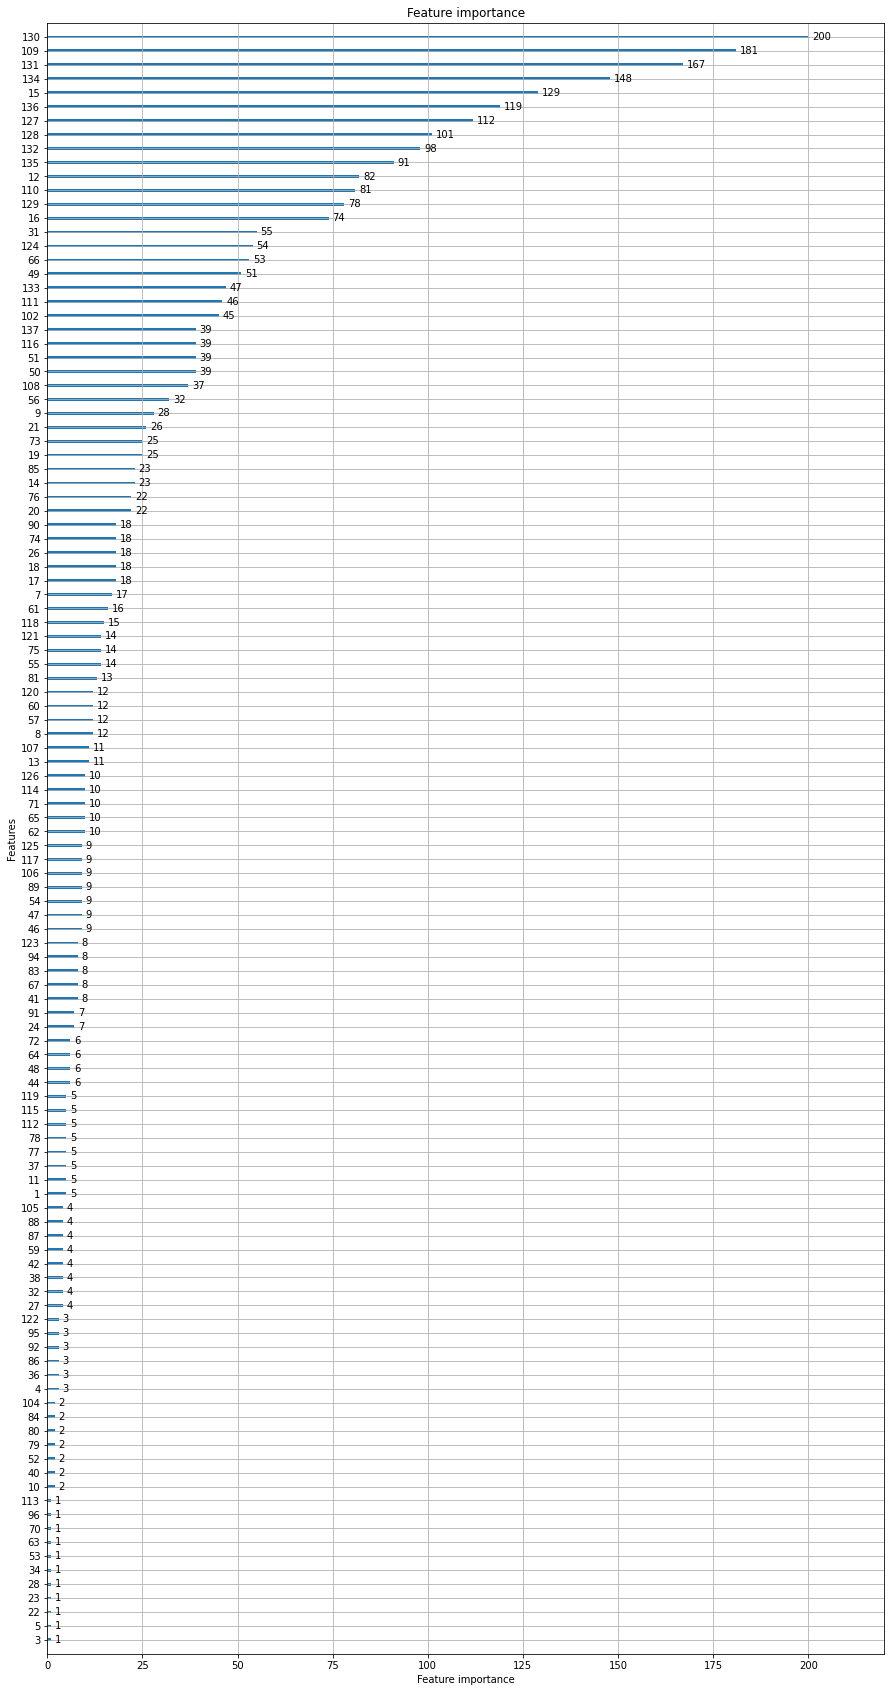

In [ ]:
# lightgbm.plot_importance(model_gbm, max_num_features = 30)
lightgbm.plot_importance(model_gbm, figsize = (15,30))

In [ ]:
pred_gbm = model_gbm.predict(df_test)

In [ ]:
X_test = df_test
X_test["predicted_ranking"] = pred_gbm
X_test.sort_values("predicted_ranking", ascending=False)

,1,2,3,4,5,6,7,8,9,10,...,129,130,131,132,133,134,135,136,137,predicted_ranking
222559,26983,2,0,2,1,2,1.000000,0.0,1.0,0.5,...,0,2,65515,53728,5,4,403637,113532,65.361644,1.696569
159120,19108,1,0,1,1,1,1.000000,0.0,1.0,1.0,...,0,14,64698,47475,19,4,2145,38214,22.018944,1.669933
79664,9988,1,0,1,1,1,1.000000,0.0,1.0,1.0,...,0,10,65526,54222,17,4,13871,2001,14.523310,1.666836
16118,2098,3,0,3,0,3,1.000000,0.0,1.0,0.0,...,0,19,65480,55125,1,2,2109,2586,76.739955,1.655506
48452,6628,1,0,0,1,1,1.000000,0.0,0.0,1.0,...,0,4,65516,54856,1,1,362,9294,73.650488,1.652496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71405,9163,1,0,0,0,1,0.250000,0.0,0.0,0.0,...,5,0,7184,58808,1,1,0,0,0.000000,-1.480149
162309,19348,2,0,0,0,2,0.400000,0.0,0.0,0.0,...,0,0,40120,46148,14,24,0,0,0.000000,-1.486639
233716,28813,3,0,0,0,3,0.333333,0.0,0.0,0.0,...,0,0,12913,38025,1,250,0,0,0.000000,-1.487703
8814,1153,1,0,0,0,1,0.250000,0.0,0.0,0.0,...,155,0,11836,59779,1,1,0,0,0.000000,-1.488386


In [ ]:
ndcg_score([y_test], [pred_gbm])

0.9377127860883778

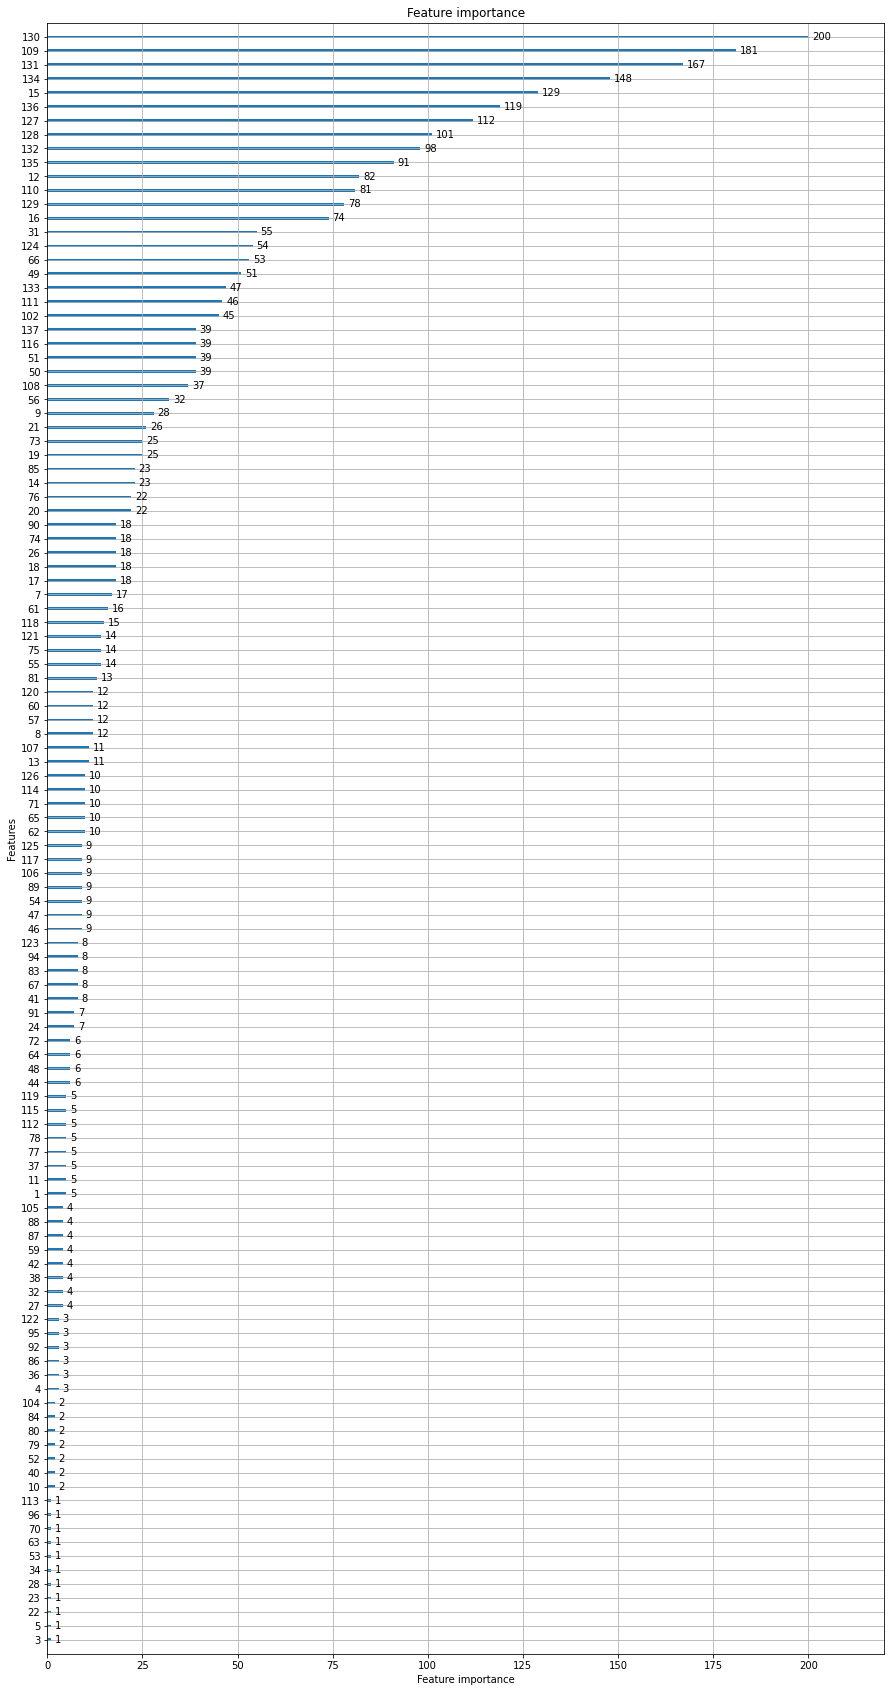

In [ ]:
# lightgbm.plot_importance(model_gbm, max_num_features = 30)
lightgbm.plot_importance(model_gbm_reg, figsize = (15,30))

**Observation**: top important features : 130, 109, 131, 134.

In [ ]:
pred_gbm_reg = model_gbm_reg.predict(df_test)

In [ ]:
ndcg_score([y_test], [pred_gbm_reg])

0.9377127860883778

**Inference**: This model seems to highly overfit the dataset and even regularization using the model_gbm_reg did not help.

**TensorFlow Ranking Model Evaluation**

In [ ]:
# evaluating the tfr model
model_tfr.evaluate(ds['test'])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


63/63 [==============================] - 15s 85ms/step - loss: 405.0630 - NDCG@10: 0.4239


[405.06304931640625, 0.42391103506088257]

**Observation**: This model seems to underfit it. Case 2 considers a more complex neural network with an additional layer of 256 neurons

In [ ]:
model_tfr_2.evaluate(ds['test'])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


63/63 [==============================] - 13s 103ms/step - loss: 404.9638 - NDCG@10: 0.4209


[404.9637756347656, 0.4209320843219757]

**Observation**: Case 2 has given no improvement from case 1. The increase in complexity by an additional layer did not help. Case 3 considers a 3 layers but with greater number of neurons compared to case 1.

In [ ]:
model_tfr_3.evaluate(ds['test'])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


63/63 [==============================] - 16s 118ms/step - loss: 404.8222 - NDCG@10: 0.4197


[404.82220458984375, 0.4197292625904083]

**Observation**: This architecture also does not improve the training or test performance.


# Observations and Inferences


Description of models used:-

1.   Linear Regression - Naive approach. A simple model to get started with the ranking process. Here the result is based on a function generated for the whole dataset, unlike a classic ranking model. This helped me get an overall idea of the ranking model.

2.   LightGBM - From http://ltr-tutorial-sigir19.isti.cnr.it/wp-content/uploads/2019/07/Part-II.pdf I learned that tree-based models are highly effective in document ranking and I wanted to try and check how it performed for the MSLR dataset. I have implemented the LightGBM.LGBMRanker (Gradient Boosting Method) model using the default gbdt - Gradient Boosted Decision Trees as the GBM algorithm. I used the available lambdarank as the objective function and ndcg(Normalized Discounted Cumulative Gain) as the evaluation metric for the LGBMRanker. Since lambdarank is for pairwise learning I was did not feel positive using it. But from https://github.com/microsoft/LightGBM/issues/3326 I learnt that the lambdamart implemented in the lightgbm reduces the listwise calculated score to pointwise and the performance is a direct indicator. The predicted ranking did not produce values in the range [0, 4] as in the case of our ground truth, instead it was within the range [-2, +2]. From https://github.com/Microsoft/LightGBM/issues/648 I understood that the reason behind such predicted values was because the output range was not specified and it generally returns outputs in such ranges. To reduce overfitting, I used the early stopping technique which is a regularization method to bring the complexity down. But it did not reduce overfitting by any significant margin.

3.   Tensorflow Ranking - As suggested in the paper (https://arxiv.org/abs/1812.00073), the tensorflow ranking is great way to implement a ranking model. I have used 3 different architectures, with greater complexities (adding more layers, more neurons) to bring the model out of the underfitting zone, but the model did not improve. I used the Adam optimizer with learning rate set as 0.01. Combining the useful features of Gradient Descent and RMS Prop algorithm, Adam gives a comprehensive coverage even with this large a dataset. I used the Softmax cross entropy loss function and ndcg was the evaluation metric.

Among all the models used, Linear Regression was too basic to provide much insight into the ranking model. In that way, the LightGBM model gave more explainable results and helped me understand the whole problem. The feature importance plot showed that the 131st, 132nd, 134th features, i.e., Pagerank, SiteRank, Query-url click count, respectively to be of high importance and it sounds logical. The tensorflow ranking allowed me to make changes in the neural network architecture and try out different combinations. I had the choice of building a complete model by deciding each parameter and building it from ground up.

Evaluation metrics used:-

1.   MSE (Mean Squared Error) for Linear Regression as usual
2.   NDCG for both LightGBM and Tensorflow ranking. The Discounted Cumulative Gain (DCG) is used for graded relevance and is the summation of the product of Gain (G) and Discount(D). The Normalized Discounted Cumulative Gain is described as DCG/IDCG, IDCG is the Ideal DCG. This NDCG was the only ranking metric available in lightgbm (https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRanker.html) and was available in tensorflow as well. It is a useful and an important metric as NDCG value gives an idea of which document is more relevant and which is less relevant by giving a high value to relevant documents. This way we can get to rank the documents by their relevance.

Model Performances:-

The models did not give high performance and they were either too simple and were underfitting the dataset, or were overfitting. As I researched about all other implementations using this dataset the model performance in those cases were also averaging out to this range (ndcg values from 0.47 to 0.58 for training). LightGBM training ndcg was 0.488 but the test ndcg was very high and did not help me arrive at any conclusion. Among the models I tried, the tensorflow ranking model gave ndcg values of 0.45 and 0.42 for training and test respectively.

Future Scope:-

1.   Research more on tree-based ranking techniques and implement pruning for feature reduction.
2.   Learn and implement optuna to optimize the hyperparameters in both lightgbm and tensorflow to improve the model performance.
3.   Wanted to implement these models on all the folds of the dataset. Additionally, RAM and GPU constraints were also a major factor for not considering all the folds. I have implemented all the models on Folds 2 and 3 separately. The performance of the models on Folds 2 and 3 are also similar to that of Fold 1.

If there was an additional feature, "user_id" it would have definitely helped in the ranking and grouping. Especially a feature that could uniquely identify the query-document pair can make the ranking more easier to comprehend. This would have given a better understanding of the relationship between the user and the query-document(url) and produce ranking results specific to users.



After performing all the Natural Language Processing(NLP) preprocessing methods (like converting the natural language to word embeddings using pretrained networks like BERT), query_text, body_text etc., can give more context to the dataset and improve its performance. The context would have been able to reveal dependencies between title_text, query_text and body_text so as to develop models coherent to these dependencies.